In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [2]:
# Load the experiment data
mem = Memory("./mycache")

@mem.cache
def get_data(f):
    data = load_svmlight_file(f)    
    return data

Loss Function:
$$ L= \frac{1}{N}\sum_{i}\sum_{j\ne y_i}[max(0,f(x_i;W)_j-f(x_i;W)_{y_i}+\Delta]+\lambda \sum_k\sum_lW^2_{k,l}$$
Gradient Matrix:
$$ \frac{\partial L}{\partial w_{y_i}}=-(\sum_{j \ne y_i}1(w^T_jx_i-w^T_{y_i}x_i+\Delta>0))x_i \quad \quad (j=y_i)$$
$$ \frac{\partial L}{\partial w_j}=1(w^T_jx_i-w^T_{y_i}x_i+\Delta>0))x_i \quad \quad \quad \quad (j\ne y_i)$$
where l(x) is an indicator function：
$$l(x==T)=1$$
$$l(x==F)=0$$

In [3]:
def predict(W , X, y ):
    """
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - x: A numpy array of shape (N, D) containing a minibatch of training data.
    - y: A numpy array of shape (N,) containing training labels; ytrain[i] = c means that xtrain[i] has label c, where 0 <= c <C.
   
    Returns a tuple of:
    - prediction of y
    - accuracy of the model
    """
    # the class scores for all examples
    score = np.dot(X,W)
    # find the index with max score in each column (the predicted class)
    y_pred= np.argmax(score, axis = 1)
    # and calculate accuracy (fraction of predictions that are correct)
    cmp=(y_pred == y)
    accuracy=len(cmp[cmp==True])/len(cmp)
    
    return y_pred,accuracy 

In [4]:
def svm(W, xtrain, ytrain, xtest, ytest, threshold, reg):
  """
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - xtrain: A numpy array of shape (num_train, D) containing a minibatch of training data.
  - ytrain: A numpy array of shape (num_train,) containing training labels; ytrain[i] = c means that xtrain[i] has label c, where 0 <= c <C.
  - xtest: A numpy array of shape (num_test, D) containing a minibatch of test data.
  - ytest: A numpy array of shape (num_test,) containing test labels
  - threshold: mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative.
  - reg: (float) regularization strength
  
  Returns a tuple of:
  - train_loss as single float
  - test_loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero  
  num_classes = W.shape[1]
  #train 
  train_loss = 0
  scores_train = xtrain.dot(W)  # num_train by C
  num_train = xtrain.shape[0]
  scores_train_correct = scores_train[np.arange(num_train), ytrain] # 1 by num_train
  scores_train_correct = np.reshape(scores_train_correct, (num_train, 1)) # num_train by 1
  margins_train = scores_train - scores_train_correct + 1.0 # num_train by C
  margins_train[np.arange(num_train), ytrain] = 0.0 
  margins_train[margins_train <= threshold] = 0.0
  train_loss += np.sum(margins_train) / num_train
  train_loss += reg * np.sum(W * W) 
  margins_train[margins_train > threshold] = 1.0                       
  row_sum = np.sum(margins_train, axis=1)                  # 1 by num_train
  margins_train[np.arange(num_train), ytrain] = -row_sum  
  dW += np.dot(xtrain.T, margins_train)/num_train + reg * W     # D by C
  #test
  test_loss = 0
  scores_test = xtest.dot(W)  # num_test by C
  num_test = xtest.shape[0]
  scores_test_correct = scores_test[np.arange(num_test), ytest] # 1 by N
  scores_test_correct = np.reshape(scores_test_correct, (num_test, 1)) # N by 1
  margins_test = scores_test - scores_test_correct + 1.0 # N by C
  margins_test[np.arange(num_test), ytest] = 0.0 
  margins_test[margins_test <= threshold] = 0.0
  test_loss += np.sum(margins_test) / num_test
  test_loss += reg * np.sum(W * W)

  return train_loss, test_loss, dW


In [5]:
# Data preparation  
data = get_data(f="D:\研一\课件\深度学习\libsvm-3.22\Australian_scale")
# Data preprocessing
X=data[0].toarray()
X= np.column_stack((X,np.ones([X.shape[0],1]))) #add bias 
Y=data[1]
Y=Y.reshape(len(Y),order='C') 
Y=Y.astype(np.int)  # float->int
Y[Y== -1]=0

________________________________________________________________________________
[Memory] Calling __main__-C%3A-Users-yingting.huang-Deep Learning-__ipython-input__.get_data...
get_data(f='D:\\研一\\课件\\深度学习\\libsvm-3.22\\Australian_scale')
_________________________________________________________get_data - 0.0s, 0.0min


In [6]:
# Devide dataset
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.4, random_state=42)
N,D=x_train.shape # N is batch size; D is input dimension
C=len(list(set(y_train))) # total number of labels

In [7]:
# Initialize parameter  
W = np.zeros((D, C)) # weights
maxIterations=1000
threshold=0 #mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative.
reg= 0.1 #regularization strength
eta = 0.01 # learning rate
L_train=[]; # train loss
L_validation=[]; #validation loss

In [8]:
# Iterations 
for t in range(maxIterations):
   
    # Compute loss
    train_loss, validation_loss, grad_W= svm(W, x_train, y_train,  x_validation, y_validation, threshold, reg)
    
    # Save the values
    L_train.append (train_loss)
    L_validation.append (validation_loss)
    
    # Update weights using gradient descent
    W -= eta * grad_W
    

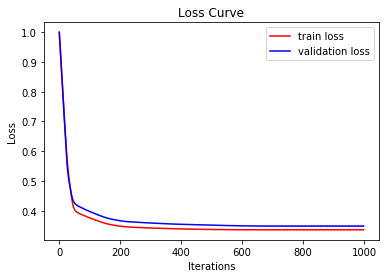

In [13]:
# Plot 
plt.plot(L_train,'r',label='train loss')
plt.plot(L_validation,'b',label='validation loss')
plt.title('Loss Curve') # give plot a title
plt.xlabel('Iterations')# make axis labels
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Assessment Result
y_train_pred,training_accuracy = predict(W , x_train, y_train )
print('------------Assessment Results-----------\ntraining accuracy=',training_accuracy)

#Predicted Result
y_validation_pred,validation_accuracy = predict(W , x_validation, y_validation )
print('\n------------Predicted Results------------\nvalidation accuracy=',validation_accuracy)

------------Assessment Results-----------
training accuracy= 0.857487922705314

------------Predicted Results------------
validation accuracy= 0.8514492753623188
